# Tutorial 10

## template fitting pysm data test (B mode)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
import seaborn as sns
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

np.random.seed(233)

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### run `preprocess` to get covariance matrix M and noise average

In [2]:
%%time

FREQS = [95.,150.]
NMAP = 2

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f[1:]
tmpmap[353] = map353f[1:]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=None,
                      likelihood='simple',foreground=syncdustmodel,background=cambmodel)

RESAMP = 100
APOSCALE = 6.
PSBIN = 80

pipeline.debug=False
inter = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)

CPU times: user 1h 51min 56s, sys: 17.5 s, total: 1h 52min 14s
Wall time: 14min 38s


#### run `analyse` to apply Bayesian sampler

- with simple (Gaussian) likelihood

iter: 13509 | +1000 | bound: 22 | nc: 1 | ncall: 69459 | eff(%): 20.889 | loglstar:   -inf < -1.412 <    inf | logz: -15.236 +/-  0.221 | dlogz:  0.001 >  1.009                                      

CPU times: user 53.7 s, sys: 3.92 s, total: 57.6 s
Wall time: 51.2 s


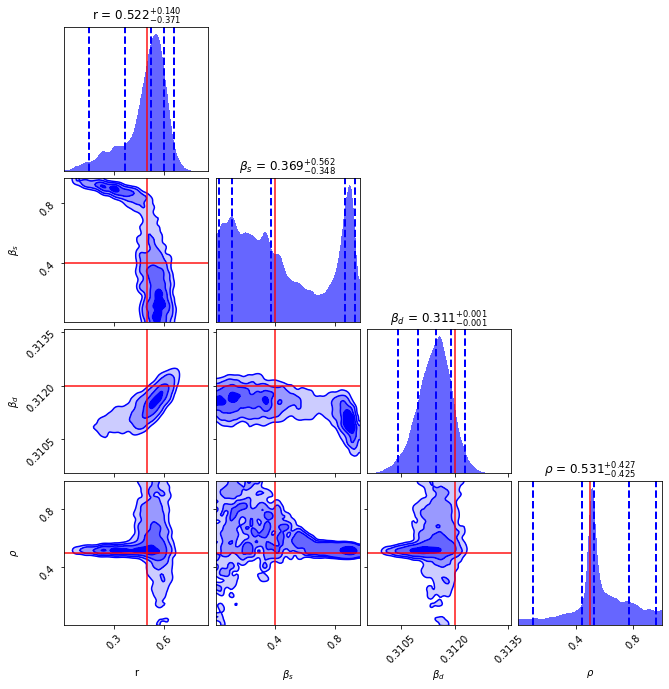

In [3]:
%%time

KWARGS = {'nlive':1000}

result = pipeline.analyse(inter[0],inter[1],inter[2],kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.,1.56/5.,0.5]
labels = [r'r',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.16, 0.5, 0.84, 0.975])

- with HL likelihood

iter: 9716 | +1000 | bound: 16 | nc: 1 | ncall: 59555 | eff(%): 17.993 | loglstar:   -inf < -2.190 <    inf | logz: -12.155 +/-  0.160 | dlogz:  0.001 >  1.009                                       

CPU times: user 1min 28s, sys: 3.11 s, total: 1min 31s
Wall time: 1min 25s


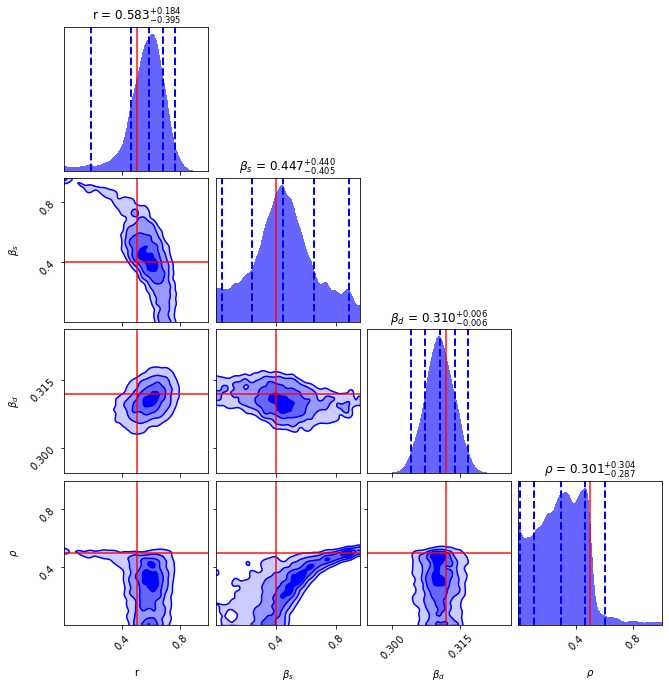

In [4]:
%%time

KWARGS = {'nlive':1000}

pipeline.likelihood = 'hl'
result = pipeline.analyse(inter[0],inter[1],inter[2],kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.,1.56/5.,0.5]
labels = [r'r',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.16, 0.5, 0.84, 0.975])

#### process new measurements with `reprocess`, run Bayesian analysis again

In [5]:
%%time
# re-run the analysis many times
rerun = 5

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])

for i in range(rerun):
    # remock measurements
    nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
    nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
    ell = np.arange(cmb_cl.shape[1])
    mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
    map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
    map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
    fullmap = dict()
    fullmap[95] = map95[1:]
    fullmap[150] = map150[1:]
    # re-process new measurements
    new_x = pipeline.reprocess(fullmap,inter[3])
    # re-run Bayesian analysis
    KWARGS = {'nlive':1000}
    pipeline.likelihood = 'hl'
    result = pipeline.analyse(new_x,inter[1],inter[2],kwargs=KWARGS)
    _samples, _weights = result.samples, np.exp(result.logwt - result.logz[-1])
    samples = np.r_[samples,_samples]
    weights = np.r_[weights,_weights]

iter: 8530 | +1000 | bound: 13 | nc: 1 | ncall: 53411 | eff(%): 17.843 | loglstar:   -inf < -0.865 <    inf | logz: -9.463 +/-  0.136 | dlogz:  0.001 >  1.009                                        

CPU times: user 8min 50s, sys: 11.2 s, total: 9min 2s
Wall time: 6min 19s


r 0.6386135199051836 0.14310465560631608
$\beta_s$ 0.39949376647679413 0.22738506593208332
$\beta_d$ 0.31220480905368697 0.00332511663648507
$\rho$ 0.4296106534726501 0.24660164673137774


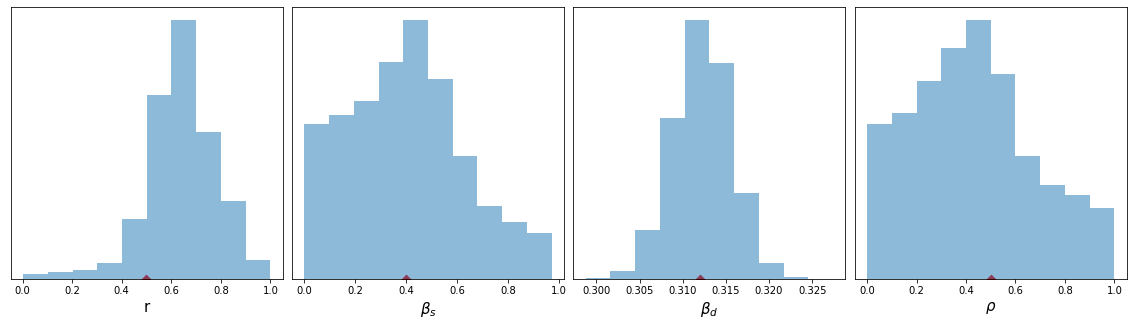

In [6]:
resamples = dyfunc.resample_equal(samples, weights)

fig = plt.figure(figsize=(20,5))
gs = gsp.GridSpec(5, 20)

for i in range(4):
    ax = fig.add_subplot(gs[:,i*5:(i+1)*5])
    ax.hist(resamples[:,i],density=True,alpha=0.5)
    ax.scatter(truths[i],0,marker='D',color='red')
    ax.set_xlabel(labels[i],fontsize=15)
    ax.set_yticks([])
    print (labels[i],np.mean(resamples[:,i]),np.std(resamples[:,i]))

end